# Analysing Se implanted single layer MoS2
Eoghan O'Connell, EMAG 2D Materials, MMC 2019

In this Jupyter Notebook we will:
1. Load, calibrate and filter an atomic resolution scanning transmission electron microscopy (STEM) image. Go to https://hyperspy.org/ for more info on getting started with TEM analysis.
2. Load and plot refined atomic positions. See the detailed Notebook for details on how to find and refine these positions, or visit the Atomap documentation here: https://atomap.org/.
3. Create a .cif (crystallographic information file) to view the created structure with the Atomic Simulation Environment (ASE) package https://wiki.fysik.dtu.dk/ase/.
4. Create a .xyz file suitable for fast image simulation with the PyPrismatic package http://prism-em.com/.
5. Refine the structure by finding missed atoms and comparing experiment to simulation.

The image was taken by Prof. Quentin Ramasse using the Nion UltraSTEM in SuperStem, Daresbury.


### First, import the python packages 

In [1]:
%matplotlib nbagg
import hyperspy.api as hs
import atomap.api as am
from atomap.atom_finding_refining import subtract_average_background
from atomap.atom_finding_refining import normalize_signal
import data.my_code_functions_all as temul
import numpy as np
from ase.io import read, write
from ase.visualize import view
import pandas as pd
import matplotlib.pyplot as plt

### Load and plot the data with hyperspy
Use the zoom tool to get a closer look.

<IPython.core.display.Javascript object>


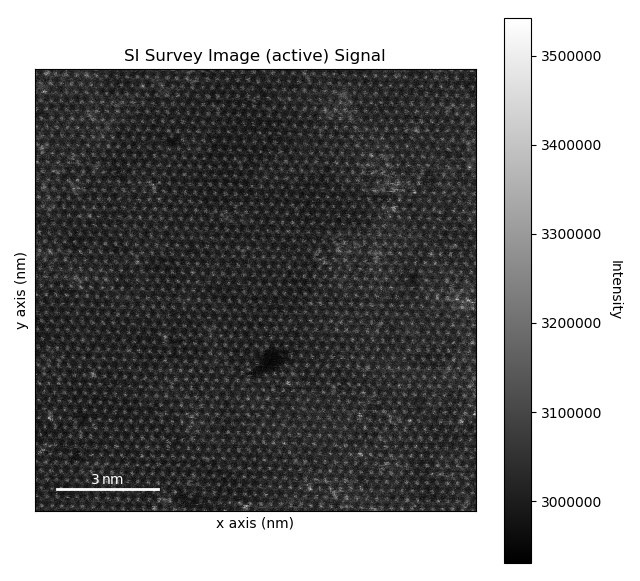

In [2]:
folder = 'data/'
filename = ''
s_original, real_sampling = temul.load_data_and_sampling(filename=folder + 'raw_haadf_mos2.dm3', save_image=False)
s_original.plot()

### Calibrate the data
Choose the region (top left & bottom right) used for calibration by clicking on the image.

<IPython.core.display.Javascript object>


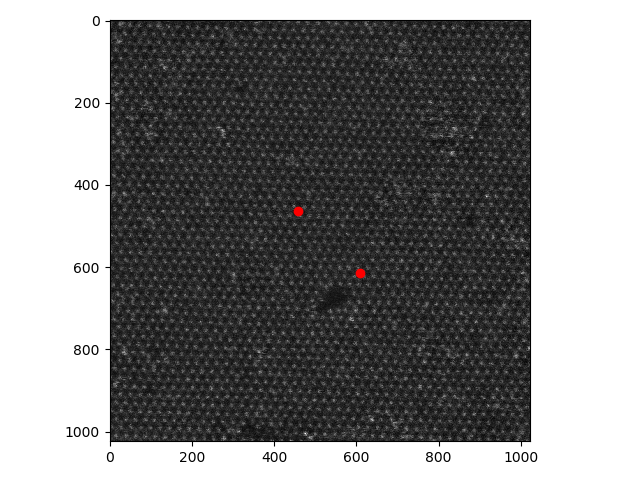

In [3]:
s_calib = normalize_signal(subtract_average_background(s_original))
s_calib.metadata = s_original.metadata
s_calib.axes_manager = s_original.axes_manager
cal_sep = 15
percent_to_nn = None
mask_radius_sub1 = temul.atomic_radii_in_pixels(real_sampling, 'Mo')
mask_radius_sub2 = temul.atomic_radii_in_pixels(real_sampling, 'S')
mask_radius_both = [mask_radius_sub1, mask_radius_sub2]

cal_area = am.add_atoms_with_gui(s_calib.data)

Gaussian fitting: 100%|████████████████████████| 27/27 [00:00<00:00, 71.43it/s]


<IPython.core.display.Javascript object>


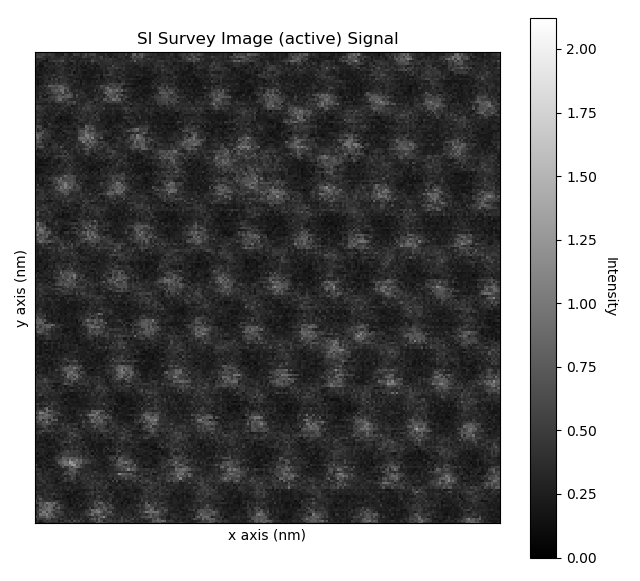

In [4]:
# if you get an error asking for cropping_area, you haven't chosen the area in the above cell!
# Can calibrate in Atomap with ADF detector response.
temul.calibrate_distance_and_intensity(image=s_calib, cropping_area=cal_area, separation=cal_sep, filename=None, 
                                       percent_to_nn=percent_to_nn, mask_radius=mask_radius_sub1, scalebar_true=True)
s_calib.plot()

### Filter the Image

Gaussian fitting: 100%|████████████████████████| 29/29 [00:00<00:00, 72.32it/s]


<IPython.core.display.Javascript object>


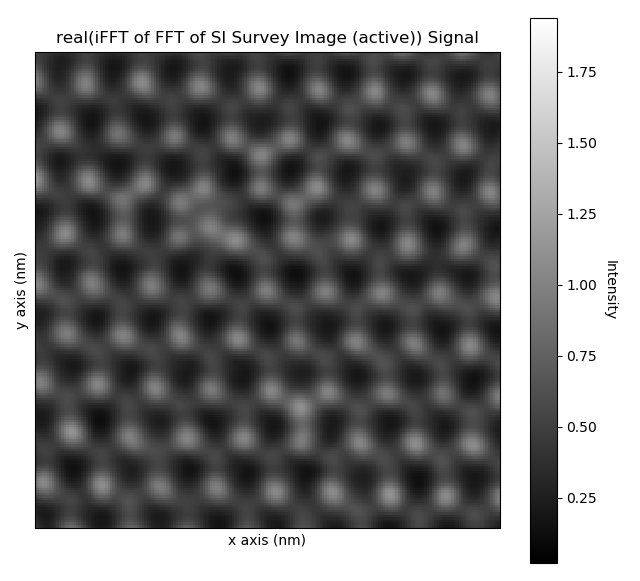

In [5]:
d_inner=7.48
d_outer=20.83
s_filtered = temul.DG_filter(image=s_calib, d_inner=d_inner, d_outer=d_outer, filename=None, delta=0.1, 
                             real_space_sampling=real_sampling, units='nm')
temul.calibrate_distance_and_intensity(image=s_filtered, cropping_area=cal_area, separation=cal_sep, filename=None, 
                                       percent_to_nn=percent_to_nn, mask_radius=mask_radius_sub1, scalebar_true=True)
s_filtered.plot()
s = s_filtered

### Load the atom lattice
If you wish to find the atomic coordinates, try the detailed Notebook!

In [6]:
atom_lattice = am.load_atom_lattice_from_hdf5(folder + 'Atom_Lattice.hdf5', construct_zone_axes=False)
sub1 = atom_lattice.sublattice_list[0]
sub2 = atom_lattice.sublattice_list[1]
sub3 = atom_lattice.sublattice_list[2]

<IPython.core.display.Javascript object>


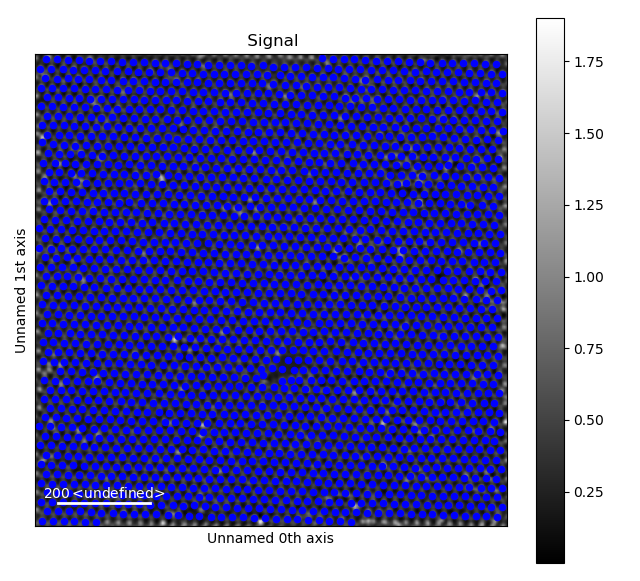

In [7]:
# Plot the first sublattice (Molybdenum/Transition Metal). 
sub1.plot()

In [8]:
# If you would like to change the color of each sublattice:

#atom_lattice.sublattice_list[0]._plot_color = 'red' # Transition metal
#atom_lattice.sublattice_list[1]._plot_color = 'blue' # Chalcogen
#atom_lattice.sublattice_list[2]._plot_color = 'yellow' # center of hexagon

### Calculate the Z-contrast exponent

In [8]:
intensity_type = 'max'
num_points = 3
method = 'mode'
bkgr_method = 'local'
background_sublattice = sub3

element_list_sub1 = ['Mo_0', 'Mo_1', 'Mo_1.S_1', 'Mo_1.Se_1', 'Mo_2']
standard_element_sub1 = 'Mo_1'
element_list_sub2 = ['S_0', 'S_1', 'S_2', 'Se_1', 'Se_1.S_1', 'Se_2']
standard_element_sub2 = 'S_2'
element_list_sub3 = ['H_0', 'S_1', 'Se_1', 'Mo_1', ]
elements_from_sub1 = ['Mo_1'] 
elements_from_sub2 = ['S_1', 'Se_1']
individual_element_list = ['Mo', 'S', 'Se']

element_list = element_list_sub1 + element_list_sub2 + element_list_sub3
element_list = list(set(element_list)) # get rid of duplicates
element_list = sorted(element_list)

image_size_x_nm = real_sampling * s.data.shape[-1]
image_size_y_nm = real_sampling * s.data.shape[-2]
image_size_z_nm = 1.2294/2

counts_no_ref = pd.DataFrame(columns=element_list)
count_atoms = temul.count_atoms_in_sublattice_list([sub1, sub2, sub3], filename=None)
counts_no_ref = counts_no_ref.append(count_atoms, ignore_index=True).fillna(0)
indiv_elems = temul.count_all_individual_elements(individual_element_list, counts_no_ref)
indiv_elems_no_ref = pd.DataFrame.from_dict(indiv_elems)
counts_no_ref = pd.concat([indiv_elems_no_ref, counts_no_ref], axis=1)

scaling_ratio, scaling_exponent, sub1_mode, sub2_mode = temul.scaling_z_contrast(numerator_sublattice=sub1, 
                                                                                 numerator_element=standard_element_sub1,
                                               denominator_sublattice=sub2, denominator_element=standard_element_sub2,
                                               intensity_type=intensity_type, method=method, 
                                               remove_background_method=bkgr_method, 
                                               background_sublattice=background_sublattice, 
                                               num_points=num_points, percent_to_nn=percent_to_nn, mask_radius=mask_radius_both)
print("Z-Contrast is Z^%.3f" %scaling_exponent)

Z-Contrast is Z^1.584


### Assign each position elements and z-coordinates

In [9]:
mid_sub1, lim_sub1 = temul.find_middle_and_edge_intensities(sublattice=sub1, element_list=element_list_sub1,
                                                      standard_element=standard_element_sub1, scaling_exponent=scaling_exponent)
mid_sub2, lim_sub2 = temul.find_middle_and_edge_intensities(sublattice=sub2, element_list=element_list_sub2,
                                                      standard_element=standard_element_sub2, scaling_exponent=scaling_exponent)

# Set sub1 elements and z coordinates
elements_of_sub1 = temul.sort_sublattice_intensities(sub1, intensity_type, mid_sub1, lim_sub1, element_list_sub1, method=method, 
                                               remove_background_method=bkgr_method, 
                                               background_sublattice=background_sublattice, num_points=num_points, 
                                               percent_to_nn=percent_to_nn, mask_radius=mask_radius_sub1)
temul.assign_z_height(sub1, lattice_type='transition_metal', material='mos2_one_layer')
sub1_info = temul.print_sublattice_elements(sub1)

In [10]:
# inspect the assigned information
sub1_info

[['Mo_1', '0.5', 1.0758105065678976, 1.0, 1.0, 1.0],
 ['Mo_1', '0.5', 1.0601530557245888, 1.0, 1.0, 1.0],
 ['Mo_1', '0.5', 1.0381609833323375, 1.0, 1.0, 1.0],
 ['Mo_1.S_1', '0.5, 0.95', 1.1646981995397871, 1.0, 1.0, 1.0],
 ['Mo_1.S_1', '0.5, 0.95', 1.2073994388468974, 1.0, 1.0, 1.0],
 ['Mo_1.S_1', '0.5, 0.95', 1.1695273967566417, 1.0, 1.0, 1.0],
 ['Mo_1.S_1', '0.5, 0.95', 1.1621132101295137, 1.0, 1.0, 1.0],
 ['Mo_1.S_1', '0.5, 0.95', 1.134040612013176, 1.0, 1.0, 1.0],
 ['Mo_1.S_1', '0.5, 0.95', 1.0610089194971923, 1.0, 1.0, 1.0],
 ['Mo_1', '0.5', 1.0405479696702764, 1.0, 1.0, 1.0],
 ['Mo_1.S_1', '0.5, 0.95', 1.0796207977117496, 1.0, 1.0, 1.0],
 ['Mo_1.S_1', '0.5, 0.95', 1.277956262930861, 1.0, 1.0, 1.0],
 ['Mo_1', '0.5', 1.0168179425254433, 1.0, 1.0, 1.0],
 ['Mo_1', '0.5', 0.9012709166342329, 1.0, 1.0, 1.0],
 ['Mo_1', '0.5', 0.9607669923704978, 1.0, 1.0, 1.0],
 ['Mo_1', '0.5', 0.6344351929957888, 1.0, 1.0, 1.0],
 ['Mo_1', '0.5', 1.0787467597923779, 1.0, 1.0, 1.0],
 ['Mo_1', '0.5', 0.94

### Create a Crystallographic Information File (.cif)

In [11]:
df_cif = temul.create_dataframe_for_cif(sublattice_list=[sub1, sub2, sub3], element_list=element_list)  
cif_filename='Example_CIF'
temul.write_cif_from_dataframe(dataframe=df_cif, filename=cif_filename, chemical_name_common='MoSx-1Sex',
                               cell_length_a=image_size_x_nm*10,
                               cell_length_b=image_size_y_nm*10,
                               cell_length_c=image_size_z_nm*10)

Writing block_1, <CifFile.CifFile.CifBlock object at 0x00000000052C6400>
All blocks output.


### Visualise the .cif data alongside the image (ASE package)

<IPython.core.display.Javascript object>


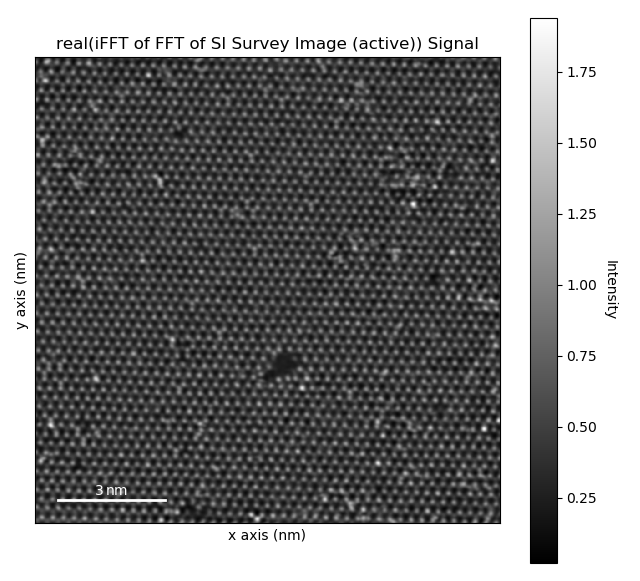

In [12]:
mos2_structure = read(cif_filename + '.cif')
view(mos2_structure)
s.plot()

### Create a .xyz file for fast image simulation

In [13]:
xyz_filename = 'Example_XYZ'
df_xyz = temul.create_dataframe_for_xyz(sublattice_list=[sub1, sub2, sub3], element_list=element_list,
                                         x_distance=image_size_x_nm*10,
                                         y_distance=image_size_y_nm*10,
                                         z_distance=image_size_z_nm*10,
                                         filename=xyz_filename,
                                         header_comment='MoSx-1Sex')

# ***Could have part here where I compare image to sim via intensity profile

### Simulate the .xyz file (PyPrismatic package)

Gaussian fitting: 100%|████████████████████████| 29/29 [00:00<00:00, 75.91it/s]


<IPython.core.display.Javascript object>


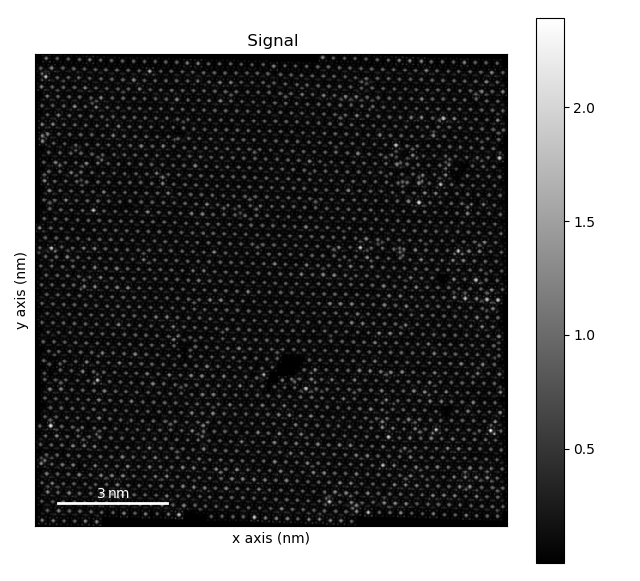

In [14]:
simulation = temul.simulate_with_prismatic(image=s,
                       xyz_filename=folder + xyz_filename,
                       filename='test',
                       calibration_area=cal_area,
                       calibration_separation=cal_sep,
                       percent_to_nn=percent_to_nn,
                       mask_radius=mask_radius_sub2,
                       interpolationFactor=64)

C:\Users\Eoghan.OConnell\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


<IPython.core.display.Javascript object>


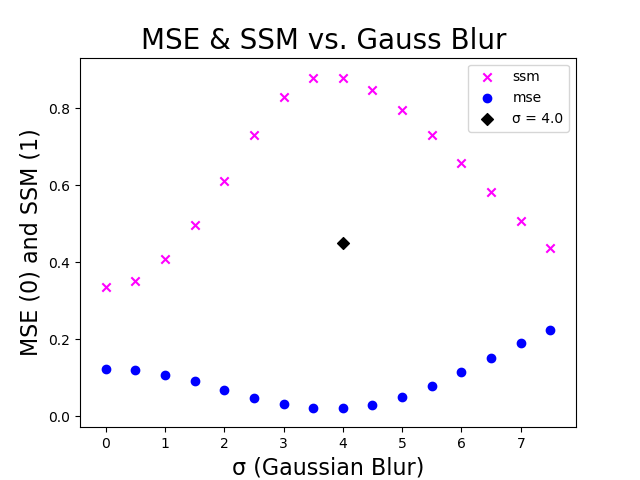

In [15]:
filtered_simulation = temul.compare_image_to_filtered_image(image_to_filter=simulation, reference_image=s, filename='',
                                    delta_image_filter=0.5, cropping_area=cal_area, separation=cal_sep,
                                    max_sigma=7.5, percent_to_nn=percent_to_nn, mask_radius=mask_radius_sub2)

<IPython.core.display.Javascript object>


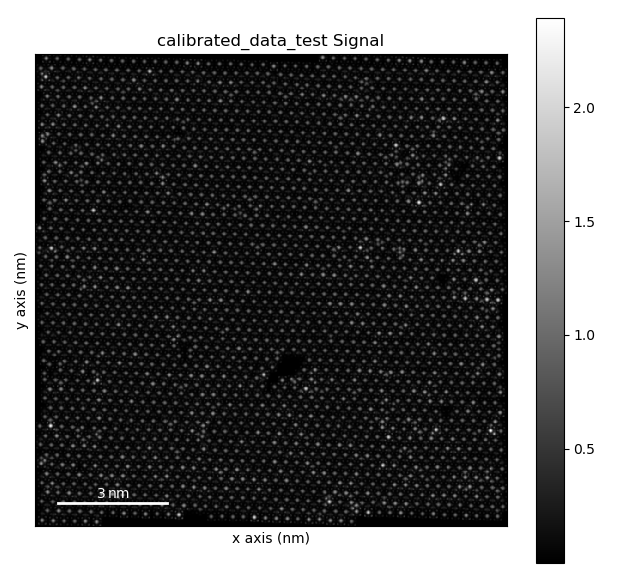

<IPython.core.display.Javascript object>


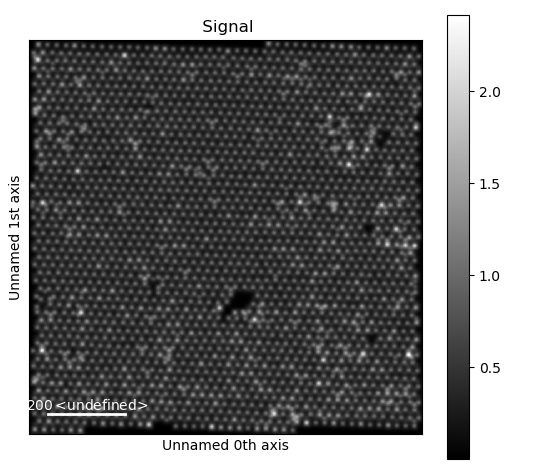

<IPython.core.display.Javascript object>


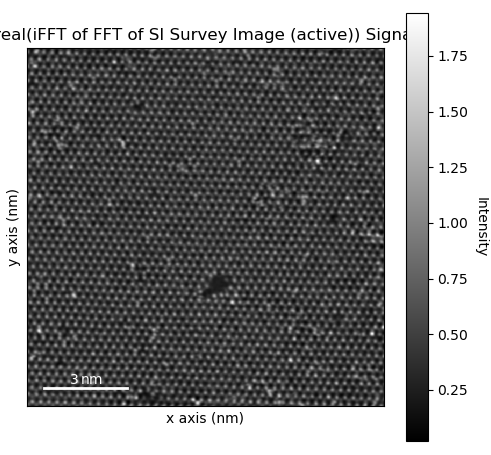

In [16]:
simulation.plot()
filtered_simulation.plot()
s.plot()

### Refine the structure by finding missing atom positions

Gaussian fitting: 100%|████████████████████████| 25/25 [00:01<00:00, 20.39it/s]


New Atoms Found! Adding to a new sublattice


<IPython.core.display.Javascript object>


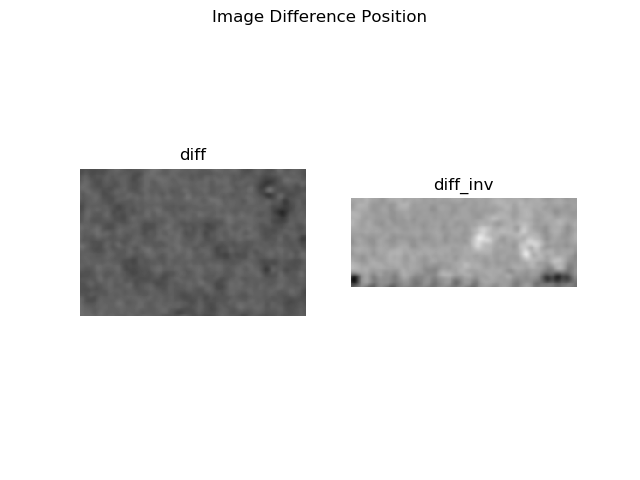

<IPython.core.display.Javascript object>


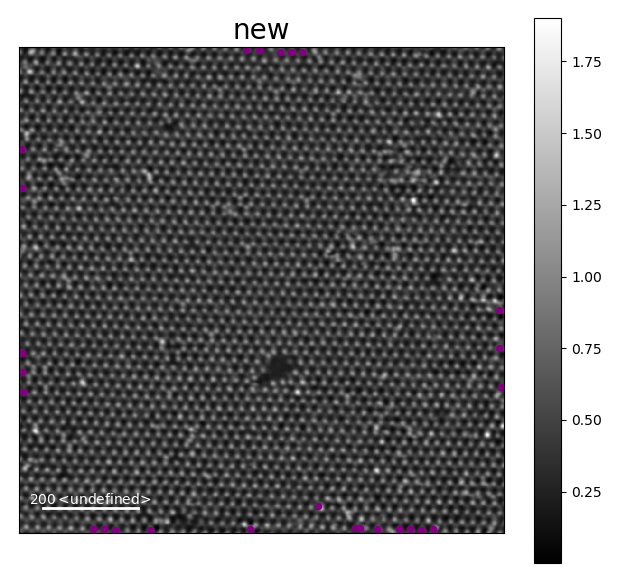

In [17]:
sub_new = temul.image_difference_position(sublattice_list=[sub1, sub2, sub3],
                                          simulation_image=filtered_simulation,
                                          pixel_threshold=5,
                                          filename='',
                                          mask_radius=mask_radius_sub2,
                                          num_peaks=25,
                                          add_sublattice=True,
                                          sublattice_name='new')

elements_of_sub_new = temul.sort_sublattice_intensities(sub_new, intensity_type, mid_sub2, lim_sub2, element_list_sub2, 
                                                     method=method, remove_background_method=bkgr_method, 
                                                     background_sublattice=background_sublattice, num_points=num_points, 
                                                     percent_to_nn=percent_to_nn, mask_radius=mask_radius_sub2)
temul.assign_z_height(sub_new, lattice_type='chalcogen', material='mos2_one_layer')

In [19]:
counts_pos_ref = pd.DataFrame(columns=element_list)
count_atoms = temul.count_atoms_in_sublattice_list([sub1, sub2, sub3, sub_new], filename=None)
counts_pos_ref = counts_pos_ref.append(count_atoms, ignore_index=True).fillna(0)

indiv_elems = temul.count_all_individual_elements(individual_element_list, counts_pos_ref)
indiv_elems_pos_ref = pd.DataFrame.from_dict(indiv_elems)
counts_pos_ref = pd.concat([indiv_elems_pos_ref, counts_pos_ref], axis=1)

### Refine the structure by comparing experiment to simulation intensity

Changing some atoms


<IPython.core.display.Javascript object>


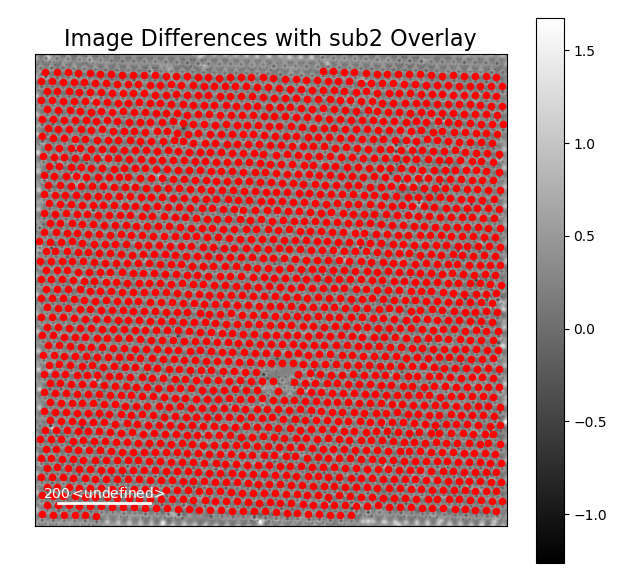

<IPython.core.display.Javascript object>


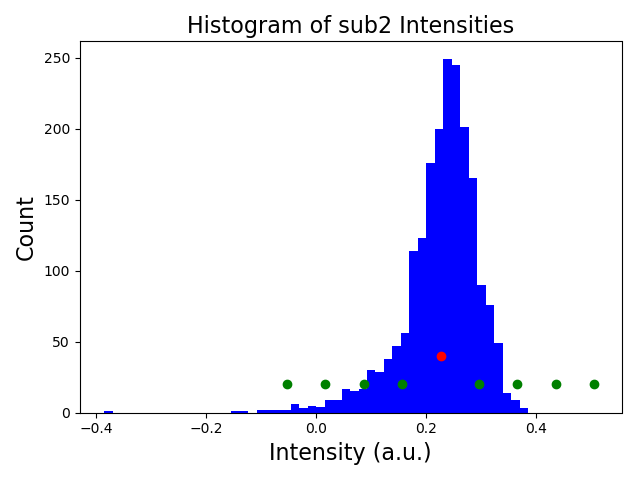

In [21]:
temul.image_difference_intensity(sublattice=sub2,
                               simulation_image=simulation,
                               element_list=element_list_sub2,
                               filename='int_ref',
                               percent_to_nn=percent_to_nn,
                               mask_radius=mask_radius_sub2,
                               change_sublattice=True)

In [25]:
counts_int_ref = pd.DataFrame(columns=element_list)
count_atoms = temul.count_atoms_in_sublattice_list([sub1, sub2, sub3, sub_new], filename=None)
counts_int_ref = counts_int_ref.append(count_atoms, ignore_index=True).fillna(0)

indiv_elems = temul.count_all_individual_elements(individual_element_list, counts_int_ref)
indiv_elems_int_ref = pd.DataFrame.from_dict(indiv_elems)
counts_int_ref = pd.concat([indiv_elems_int_ref, counts_int_ref], axis=1)

### Inspect refinement of elements

<IPython.core.display.Javascript object>


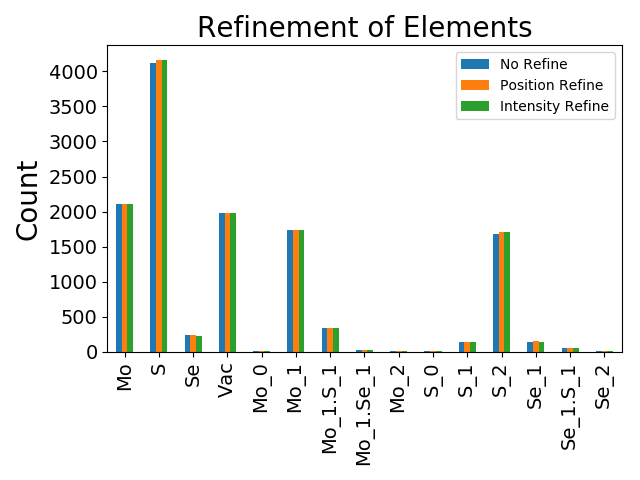

In [26]:
counts_ = pd.concat([counts_no_ref.T, counts_pos_ref.T, counts_int_ref.T], axis=1)
counts_.rename(index={'H_0':'Vac'}, inplace=True)
counts_.columns = ['No Refine', 'Position Refine', 'Intensity Refine']

ax_no_ref = counts_.plot.bar(fontsize=14)
plt.title('Refinement of Elements', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.tight_layout()
plt.show()